# Simulation of interaction effect on cell type abundance

## Author: Jun Inamo
## Date: 2025-09-14
## Email: juninamo@keio.jp
## Affiliation: Department of Microbiology and Immunology, Keio University School of Medicine, Tokyo, Japan

In [1]:
suppressPackageStartupMessages({
  library(SimSCEQTL)
  
  library(dplyr)
  library(tidyr)
  library(tidyverse)
  
  library(MASS)
  library(caret)
  
  library(Seurat)
  library(presto)
  library(ggplot2)
  library(ggrepel)
  library(glue)
  
  library(stevemisc)
  library(stevedata)
  library(lme4)
  library(broom.mixed)
  
  library(doParallel)
  library(pbapply)
  library(variancePartition)
  library(data.table)
  library(MatrixEQTL)
  library(harmony)
  library(foreach)
  library(parallel)
  
})

options(warn = -1)

# Scenario 1: Moderate interaction effect between sex and disease status (specific)

In [2]:
params <- list(
  n_thread = 1,
  n_cells = 50,
  n_individuals = 100,
  cluster_ratio = 0.65,
  batch_ratio = 0
)


In [3]:

fc_interact=0.5 # additional FC of specified cell types which are from people with case groups compared to control groups (e.g., if you specify 0.5, FC comparing increased cell type between case and control groups will be 1.5 in total)
interaction_type = c("specific") # c("specific","differential","opposite")


In [4]:
n_thread=params$n_thread
registerDoParallel(cores = n_thread)  # use forking with X cores

# parameters for generating dummy dataset
n_cells=params$n_cells # cells per major cell type
sd_celltypes=0.1  # standard deviation of number of cells 
n_major_cell_types=3 # number of major cell types
n_minor_cell_types=1 # number of minor cell types
relative_abundance=0.4 # ratio between major and rare
n_individuals=params$n_individuals # total individuals
n_batchs=4 # total batches
prop_sex=0.5 # proportion of female
prop_disease=0.5  # proportion of case
interaction_feature_1="sex"
interaction_feature_2="disease"
# interaction_feature_1="age"
# interaction_feature_2="bmi"
n_major_interact_celltypes=1 # number of major cell types which are differentially abundant between two groups. This parameter is effective only when fc_increase > 0
n_minor_interact_celltypes=1 # number of minor cell types which are differentially abundant between two groups. This parameter is effective only when fc_increase > 0

print(paste0("n_thread: ", n_thread))
print(paste0("n_cells: ", n_cells))
print(paste0("sd_celltypes: ", sd_celltypes))
print(paste0("n_major_cell_types: ", n_major_cell_types))
print(paste0("n_minor_cell_types: ", n_minor_cell_types))
print(paste0("relative_abundance: ", relative_abundance))
print(paste0("n_major_diff_celltypes: ", n_major_interact_celltypes))
print(paste0("n_minor_diff_celltypes: ", n_minor_interact_celltypes))
print(paste0("n_individuals: ", n_individuals))
print(paste0("n_batchs: ", n_batchs))
print(paste0("prop_sex: ", prop_sex))
print(paste0("prop_disease: ", prop_disease))
print(paste0("fc_interact: ", fc_interact))
print(paste0("interaction_type: ", interaction_type))


n_features = 200
cluster_features = 1:50
disease_features = 1:50
sex_features = 1:50 # seq(2, 20, by = 2)
age_features = 1:50 # seq(2, 10, by = 2)
bmi_features = 1:50 # seq(11, 20, by = 2)
batch_features = 1:100 # seq(1, 20,by = 2)
individual_features = 1:100 # seq(1, 20,by = 2)

# Define the maximum variance in features of each attribute
cluster_ratio = params$cluster_ratio
disease_ratio = 0.01
sex_ratio = 0.01 # 0.05
age_ratio = 0.01 # 0.05
bmi_ratio = 0.01 # 0.05
batch_ratio = params$batch_ratio # 0.1
individual_ratio = 0.01 # 0.1

n_pcs = 20

ratio_variance = 0.1

cluster_col = "cell_type"
sex_col = "sex"
age_col = "age"
bmi_col = "bmi"
batch_col = "batch"
disease_col = "disease"
individual_col = 'subject_id'

# parameters for UMAP
n_neighbors = 30
metric = "cosine"
min_dist = 0.01

samplem_key = 'subject_id'

# parameters for eQTL
eqtl_celltype = "A" # major cell type
eqtl_gene = "Gene1" # gene to be tested for eQTL
cor_vals = c(0, 0.15, 0.3) # correlation coefficients to be tested between expression of eqtl_gene in eqtl_celltype and genotype (dosage)
allele_freqs = c(0.05, 0.3) # allele frequencies to be tested
n_snps = 100 # number of simulation SNPs
dist_type = "nb" # c("nb","poisson") # distribution of simulated counts. nb= negative binomial, poisson= Poisson distribution
seed = 1234


[1] "n_thread: 1"
[1] "n_cells: 50"
[1] "sd_celltypes: 0.1"
[1] "n_major_cell_types: 3"
[1] "n_minor_cell_types: 1"
[1] "relative_abundance: 0.4"
[1] "n_major_diff_celltypes: 1"
[1] "n_minor_diff_celltypes: 1"
[1] "n_individuals: 100"
[1] "n_batchs: 4"
[1] "prop_sex: 0.5"
[1] "prop_disease: 0.5"
[1] "fc_interact: 0.5"
[1] "interaction_type: specific"


In [5]:
datasets = generate_data_interaction(n_cells = n_cells,
                                     sd_celltypes = sd_celltypes, 
                                     n_major_cell_types = n_major_cell_types,
                                     n_minor_cell_types = n_minor_cell_types,
                                     relative_abundance = relative_abundance, 
                                     n_major_interact_celltypes = n_major_interact_celltypes,
                                     n_minor_interact_celltypes = n_minor_interact_celltypes,
                                     interaction_feature_1 = interaction_feature_1,
                                     interaction_feature_2 = interaction_feature_2,
                                     interaction_type = interaction_type,
                                     
                                     n_individuals = n_individuals,
                                     n_batchs = n_batchs,
                                     prop_sex = prop_sex, 
                                     prop_disease = prop_disease, 
                                     fc_interact = fc_interact,
                                     
                                     n_features = n_features, 
                                     cluster_features = cluster_features,
                                     disease_features = disease_features,
                                     sex_features = sex_features, 
                                     age_features = age_features,
                                     bmi_features = bmi_features,
                                     batch_features = batch_features,
                                     individual_features = individual_features,
                                     
                                     cluster_ratio = cluster_ratio,
                                     disease_ratio = disease_ratio,
                                     sex_ratio = sex_ratio,
                                     age_ratio = age_ratio,
                                     bmi_ratio = bmi_ratio,
                                     batch_ratio = batch_ratio,
                                     individual_ratio = individual_ratio,
                                     
                                     ratio_variance = ratio_variance,
                                     
                                     cluster_col = cluster_col,
                                     sex_col = sex_col,
                                     age_col = age_col,
                                     bmi_col = bmi_col,
                                     batch_col = batch_col,
                                     disease_col = disease_col,
                                     individual_col = individual_col,
                                     
                                     dist_type = dist_type,
                                     eqtl_celltype = eqtl_celltype, 
                                     eqtl_gene = eqtl_gene,
                                     cor_vals = cor_vals,
                                     allele_freqs = allele_freqs,
                                     n_snps = n_snps, 
                                     
                                     seed = seed,
                                     n_thread = n_thread,
                                     verbose = TRUE
                                     
)

interaction_type; specific

The simulated dataset contains 400 pseudobulk samples across 100 individuals,
4 cell types,
400 genes,
with 17799 single cells in total.



In [6]:
meta_data = datasets$dummy_data
head(meta_data)
dim(meta_data)

,subject_id,sex,disease,age,batch,bmi,interaction,interact_term,cell_type,nUMI
,<chr>,<fct>,<fct>,<int>,<fct>,<int>,<chr>,<fct>,<chr>,<dbl>
61,SUB_1,1,1,33,1,31,sex:disease,1.1,B,360
16368,SUB_92,0,1,39,4,30,sex:disease,0.1,A,295
16904,SUB_95,0,1,39,3,33,sex:disease,0.1,A,348
6703,SUB_42,0,1,38,2,33,sex:disease,0.1,A,345
1560,SUB_16,0,0,19,4,24,sex:disease,0.0,C,250
10312,SUB_60,1,1,30,4,16,sex:disease,1.1,A,309


[1] 17799    10

`summarise()` has grouped output by 'subject_id', 'sex', 'disease'. You can
override using the `.groups` argument.


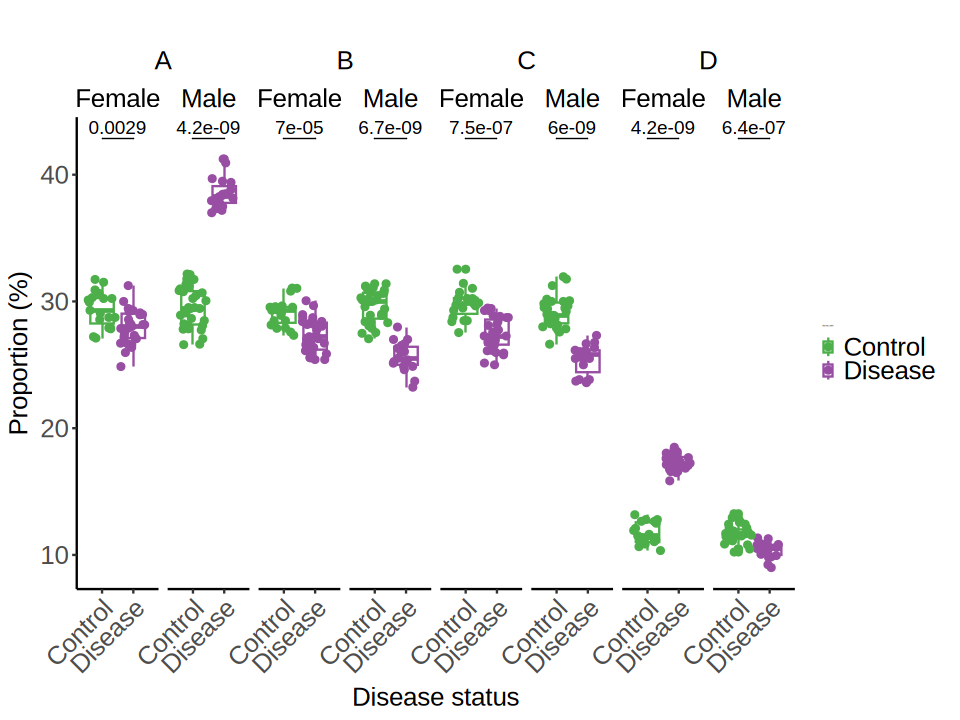

In [7]:
options(repr.plot.width=8, repr.plot.height=6)


meta_data %>%
  dplyr::group_by(subject_id,sex,disease,cell_type) %>%
  dplyr::summarise(count = dplyr::n()) %>%
  dplyr::group_by(subject_id,sex,disease) %>%
  dplyr::mutate(proportion = 100*count/sum(count),
                sex_label = ifelse(sex=="0","Male","Female"),
                disease_label = ifelse(disease=="0","Control","Disease")) %>%
  ggplot(.,aes(x=disease_label,y=proportion,color = disease_label)) +
  geom_boxplot() +
  geom_point(position=position_jitterdodge(0.9)) +
  ggpubr::stat_compare_means(comparisons = list(c("Control","Disease")), 
                             label = "{p.adj}{p.adj.signif}", method = "wilcox.test", label.y.npc = 0.4, tip.length = 0) +
  scale_color_manual(values = c(
    "Control" = "#4DAF4A",
    "Disease" = "#984EA3")) +
  ggh4x::facet_nested_wrap(vars(cell_type, sex_label), nrow = 1) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black"),
        strip.text.y=element_text(size=15, color="black"),
        strip.placement = "outside", 
        strip.background.x=element_rect(color = NA,  fill=NA), 
        strip.background.y=element_rect(color = "black",  fill=NA),
        legend.position = "right",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(
    x = "Disease status",
    y = "Proportion (%)",
    title = ""
  )  


# Scenario 2: Null interaction effect between sex and disease status

In [8]:
params <- list(
  n_thread = 1,
  n_cells = 50,
  n_individuals = 100,
  cluster_ratio = 0.65,
  batch_ratio = 0
)


In [9]:

fc_interact=0 # additional FC of specified cell types which are from people with case groups compared to control groups (e.g., if you specify 0.5, FC comparing increased cell type between case and control groups will be 1.5 in total)
interaction_type = c("specific") # c("specific","differential","opposite")


In [10]:
n_thread=params$n_thread
registerDoParallel(cores = n_thread)  # use forking with X cores

# parameters for generating dummy dataset
n_cells=params$n_cells # cells per major cell type
sd_celltypes=0.1  # standard deviation of number of cells 
n_major_cell_types=3 # number of major cell types
n_minor_cell_types=1 # number of minor cell types
relative_abundance=0.4 # ratio between major and rare
n_individuals=params$n_individuals # total individuals
n_batchs=4 # total batches
prop_sex=0.5 # proportion of female
prop_disease=0.5  # proportion of case
interaction_feature_1="sex"
interaction_feature_2="disease"
# interaction_feature_1="age"
# interaction_feature_2="bmi"
n_major_interact_celltypes=1 # number of major cell types which are differentially abundant between two groups. This parameter is effective only when fc_increase > 0
n_minor_interact_celltypes=1 # number of minor cell types which are differentially abundant between two groups. This parameter is effective only when fc_increase > 0

print(paste0("n_thread: ", n_thread))
print(paste0("n_cells: ", n_cells))
print(paste0("sd_celltypes: ", sd_celltypes))
print(paste0("n_major_cell_types: ", n_major_cell_types))
print(paste0("n_minor_cell_types: ", n_minor_cell_types))
print(paste0("relative_abundance: ", relative_abundance))
print(paste0("n_major_diff_celltypes: ", n_major_interact_celltypes))
print(paste0("n_minor_diff_celltypes: ", n_minor_interact_celltypes))
print(paste0("n_individuals: ", n_individuals))
print(paste0("n_batchs: ", n_batchs))
print(paste0("prop_sex: ", prop_sex))
print(paste0("prop_disease: ", prop_disease))
print(paste0("fc_interact: ", fc_interact))
print(paste0("interaction_type: ", interaction_type))


n_features = 200
cluster_features = 1:50
disease_features = 1:50
sex_features = 1:50 # seq(2, 20, by = 2)
age_features = 1:50 # seq(2, 10, by = 2)
bmi_features = 1:50 # seq(11, 20, by = 2)
batch_features = 1:100 # seq(1, 20,by = 2)
individual_features = 1:100 # seq(1, 20,by = 2)

# Define the maximum variance in features of each attribute
cluster_ratio = params$cluster_ratio
disease_ratio = 0.01
sex_ratio = 0.01 # 0.05
age_ratio = 0.01 # 0.05
bmi_ratio = 0.01 # 0.05
batch_ratio = params$batch_ratio # 0.1
individual_ratio = 0.01 # 0.1

n_pcs = 20

ratio_variance = 0.1

cluster_col = "cell_type"
sex_col = "sex"
age_col = "age"
bmi_col = "bmi"
batch_col = "batch"
disease_col = "disease"
individual_col = 'subject_id'

# parameters for UMAP
n_neighbors = 30
metric = "cosine"
min_dist = 0.01

samplem_key = 'subject_id'

# parameters for eQTL
eqtl_celltype = "A" # major cell type
eqtl_gene = "Gene1" # gene to be tested for eQTL
cor_vals = c(0, 0.15, 0.3) # correlation coefficients to be tested between expression of eqtl_gene in eqtl_celltype and genotype (dosage)
allele_freqs = c(0.05, 0.3) # allele frequencies to be tested
n_snps = 100 # number of simulation SNPs
dist_type = "nb" # c("nb","poisson") # distribution of simulated counts. nb= negative binomial, poisson= Poisson distribution
seed = 1234


[1] "n_thread: 1"
[1] "n_cells: 50"
[1] "sd_celltypes: 0.1"
[1] "n_major_cell_types: 3"
[1] "n_minor_cell_types: 1"
[1] "relative_abundance: 0.4"
[1] "n_major_diff_celltypes: 1"
[1] "n_minor_diff_celltypes: 1"
[1] "n_individuals: 100"
[1] "n_batchs: 4"
[1] "prop_sex: 0.5"
[1] "prop_disease: 0.5"
[1] "fc_interact: 0"
[1] "interaction_type: specific"


In [11]:
datasets = generate_data_interaction(n_cells = n_cells,
                                     sd_celltypes = sd_celltypes, 
                                     n_major_cell_types = n_major_cell_types,
                                     n_minor_cell_types = n_minor_cell_types,
                                     relative_abundance = relative_abundance, 
                                     n_major_interact_celltypes = n_major_interact_celltypes,
                                     n_minor_interact_celltypes = n_minor_interact_celltypes,
                                     interaction_feature_1 = interaction_feature_1,
                                     interaction_feature_2 = interaction_feature_2,
                                     interaction_type = interaction_type,
                                     
                                     n_individuals = n_individuals,
                                     n_batchs = n_batchs,
                                     prop_sex = prop_sex, 
                                     prop_disease = prop_disease, 
                                     fc_interact = fc_interact,
                                     
                                     n_features = n_features, 
                                     cluster_features = cluster_features,
                                     disease_features = disease_features,
                                     sex_features = sex_features, 
                                     age_features = age_features,
                                     bmi_features = bmi_features,
                                     batch_features = batch_features,
                                     individual_features = individual_features,
                                     
                                     cluster_ratio = cluster_ratio,
                                     disease_ratio = disease_ratio,
                                     sex_ratio = sex_ratio,
                                     age_ratio = age_ratio,
                                     bmi_ratio = bmi_ratio,
                                     batch_ratio = batch_ratio,
                                     individual_ratio = individual_ratio,
                                     
                                     ratio_variance = ratio_variance,
                                     
                                     cluster_col = cluster_col,
                                     sex_col = sex_col,
                                     age_col = age_col,
                                     bmi_col = bmi_col,
                                     batch_col = batch_col,
                                     disease_col = disease_col,
                                     individual_col = individual_col,
                                     
                                     dist_type = dist_type,
                                     eqtl_celltype = eqtl_celltype, 
                                     eqtl_gene = eqtl_gene,
                                     cor_vals = cor_vals,
                                     allele_freqs = allele_freqs,
                                     n_snps = n_snps, 
                                     
                                     seed = seed,
                                     n_thread = n_thread,
                                     verbose = TRUE
                                     
)

interaction_type; specific

The simulated dataset contains 400 pseudobulk samples across 100 individuals,
4 cell types,
400 genes,
with 16983 single cells in total.



In [12]:
meta_data = datasets$dummy_data
head(meta_data)
dim(meta_data)

,subject_id,sex,disease,age,batch,bmi,interaction,interact_term,cell_type,nUMI
,<chr>,<fct>,<fct>,<int>,<fct>,<int>,<chr>,<fct>,<chr>,<dbl>
61,SUB_1,1,1,33,1,31,sex:disease,1.1,B,377
16368,SUB_96,0,0,49,4,17,sex:disease,0.0,B,368
16904,SUB_99,0,0,52,3,26,sex:disease,0.0,B,408
6703,SUB_44,1,1,59,4,16,sex:disease,1.1,B,386
1560,SUB_17,0,0,28,1,15,sex:disease,0.0,A,288
10312,SUB_63,1,1,60,3,32,sex:disease,1.1,C,294


[1] 16983    10

`summarise()` has grouped output by 'subject_id', 'sex', 'disease'. You can
override using the `.groups` argument.


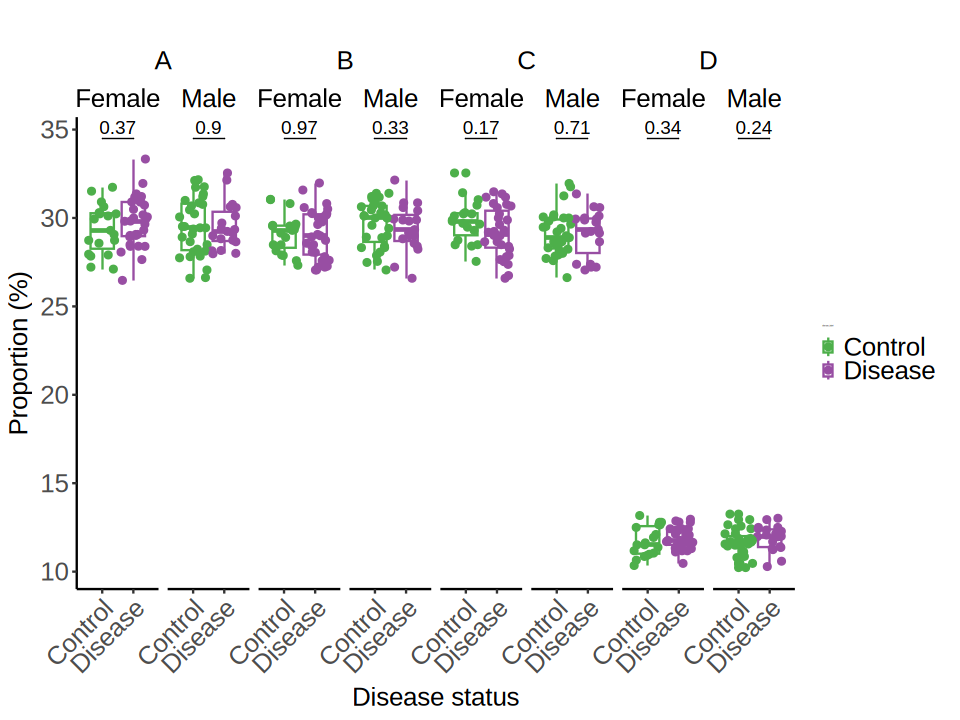

In [13]:
options(repr.plot.width=8, repr.plot.height=6)


meta_data %>%
  dplyr::group_by(subject_id,sex,disease,cell_type) %>%
  dplyr::summarise(count = dplyr::n()) %>%
  dplyr::group_by(subject_id,sex,disease) %>%
  dplyr::mutate(proportion = 100*count/sum(count),
                sex_label = ifelse(sex=="0","Male","Female"),
                disease_label = ifelse(disease=="0","Control","Disease")) %>%
  ggplot(.,aes(x=disease_label,y=proportion,color = disease_label)) +
  geom_boxplot() +
  geom_point(position=position_jitterdodge(0.9)) +
  ggpubr::stat_compare_means(comparisons = list(c("Control","Disease")), 
                             label = "{p.adj}{p.adj.signif}", method = "wilcox.test", label.y.npc = 0.4, tip.length = 0) +
  scale_color_manual(values = c(
    "Control" = "#4DAF4A",
    "Disease" = "#984EA3")) +
  ggh4x::facet_nested_wrap(vars(cell_type, sex_label), nrow = 1) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black"),
        strip.text.y=element_text(size=15, color="black"),
        strip.placement = "outside", 
        strip.background.x=element_rect(color = NA,  fill=NA), 
        strip.background.y=element_rect(color = "black",  fill=NA),
        legend.position = "right",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(
    x = "Disease status",
    y = "Proportion (%)",
    title = ""
  )  


# Scenario 3: Strong interaction effect between sex and disease status (specific)

In [14]:
params <- list(
  n_thread = 1,
  n_cells = 50,
  n_individuals = 100,
  cluster_ratio = 0.65,
  batch_ratio = 0
)


In [15]:

fc_interact=1 # additional FC of specified cell types which are from people with case groups compared to control groups (e.g., if you specify 0.5, FC comparing increased cell type between case and control groups will be 1.5 in total)
interaction_type = c("specific") # c("specific","differential","opposite")


In [16]:
n_thread=params$n_thread
registerDoParallel(cores = n_thread)  # use forking with X cores

# parameters for generating dummy dataset
n_cells=params$n_cells # cells per major cell type
sd_celltypes=0.1  # standard deviation of number of cells 
n_major_cell_types=3 # number of major cell types
n_minor_cell_types=1 # number of minor cell types
relative_abundance=0.4 # ratio between major and rare
n_individuals=params$n_individuals # total individuals
n_batchs=4 # total batches
prop_sex=0.5 # proportion of female
prop_disease=0.5  # proportion of case
interaction_feature_1="sex"
interaction_feature_2="disease"
# interaction_feature_1="age"
# interaction_feature_2="bmi"
n_major_interact_celltypes=1 # number of major cell types which are differentially abundant between two groups. This parameter is effective only when fc_increase > 0
n_minor_interact_celltypes=1 # number of minor cell types which are differentially abundant between two groups. This parameter is effective only when fc_increase > 0

print(paste0("n_thread: ", n_thread))
print(paste0("n_cells: ", n_cells))
print(paste0("sd_celltypes: ", sd_celltypes))
print(paste0("n_major_cell_types: ", n_major_cell_types))
print(paste0("n_minor_cell_types: ", n_minor_cell_types))
print(paste0("relative_abundance: ", relative_abundance))
print(paste0("n_major_diff_celltypes: ", n_major_interact_celltypes))
print(paste0("n_minor_diff_celltypes: ", n_minor_interact_celltypes))
print(paste0("n_individuals: ", n_individuals))
print(paste0("n_batchs: ", n_batchs))
print(paste0("prop_sex: ", prop_sex))
print(paste0("prop_disease: ", prop_disease))
print(paste0("fc_interact: ", fc_interact))
print(paste0("interaction_type: ", interaction_type))


n_features = 200
cluster_features = 1:50
disease_features = 1:50
sex_features = 1:50 # seq(2, 20, by = 2)
age_features = 1:50 # seq(2, 10, by = 2)
bmi_features = 1:50 # seq(11, 20, by = 2)
batch_features = 1:100 # seq(1, 20,by = 2)
individual_features = 1:100 # seq(1, 20,by = 2)

# Define the maximum variance in features of each attribute
cluster_ratio = params$cluster_ratio
disease_ratio = 0.01
sex_ratio = 0.01 # 0.05
age_ratio = 0.01 # 0.05
bmi_ratio = 0.01 # 0.05
batch_ratio = params$batch_ratio # 0.1
individual_ratio = 0.01 # 0.1

n_pcs = 20

ratio_variance = 0.1

cluster_col = "cell_type"
sex_col = "sex"
age_col = "age"
bmi_col = "bmi"
batch_col = "batch"
disease_col = "disease"
individual_col = 'subject_id'

# parameters for UMAP
n_neighbors = 30
metric = "cosine"
min_dist = 0.01

samplem_key = 'subject_id'

# parameters for eQTL
eqtl_celltype = "A" # major cell type
eqtl_gene = "Gene1" # gene to be tested for eQTL
cor_vals = c(0, 0.15, 0.3) # correlation coefficients to be tested between expression of eqtl_gene in eqtl_celltype and genotype (dosage)
allele_freqs = c(0.05, 0.3) # allele frequencies to be tested
n_snps = 100 # number of simulation SNPs
dist_type = "nb" # c("nb","poisson") # distribution of simulated counts. nb= negative binomial, poisson= Poisson distribution
seed = 1234


[1] "n_thread: 1"
[1] "n_cells: 50"
[1] "sd_celltypes: 0.1"
[1] "n_major_cell_types: 3"
[1] "n_minor_cell_types: 1"
[1] "relative_abundance: 0.4"
[1] "n_major_diff_celltypes: 1"
[1] "n_minor_diff_celltypes: 1"
[1] "n_individuals: 100"
[1] "n_batchs: 4"
[1] "prop_sex: 0.5"
[1] "prop_disease: 0.5"
[1] "fc_interact: 1"
[1] "interaction_type: specific"


In [17]:
datasets = generate_data_interaction(n_cells = n_cells,
                                     sd_celltypes = sd_celltypes, 
                                     n_major_cell_types = n_major_cell_types,
                                     n_minor_cell_types = n_minor_cell_types,
                                     relative_abundance = relative_abundance, 
                                     n_major_interact_celltypes = n_major_interact_celltypes,
                                     n_minor_interact_celltypes = n_minor_interact_celltypes,
                                     interaction_feature_1 = interaction_feature_1,
                                     interaction_feature_2 = interaction_feature_2,
                                     interaction_type = interaction_type,
                                     
                                     n_individuals = n_individuals,
                                     n_batchs = n_batchs,
                                     prop_sex = prop_sex, 
                                     prop_disease = prop_disease, 
                                     fc_interact = fc_interact,
                                     
                                     n_features = n_features, 
                                     cluster_features = cluster_features,
                                     disease_features = disease_features,
                                     sex_features = sex_features, 
                                     age_features = age_features,
                                     bmi_features = bmi_features,
                                     batch_features = batch_features,
                                     individual_features = individual_features,
                                     
                                     cluster_ratio = cluster_ratio,
                                     disease_ratio = disease_ratio,
                                     sex_ratio = sex_ratio,
                                     age_ratio = age_ratio,
                                     bmi_ratio = bmi_ratio,
                                     batch_ratio = batch_ratio,
                                     individual_ratio = individual_ratio,
                                     
                                     ratio_variance = ratio_variance,
                                     
                                     cluster_col = cluster_col,
                                     sex_col = sex_col,
                                     age_col = age_col,
                                     bmi_col = bmi_col,
                                     batch_col = batch_col,
                                     disease_col = disease_col,
                                     individual_col = individual_col,
                                     
                                     dist_type = dist_type,
                                     eqtl_celltype = eqtl_celltype, 
                                     eqtl_gene = eqtl_gene,
                                     cor_vals = cor_vals,
                                     allele_freqs = allele_freqs,
                                     n_snps = n_snps, 
                                     
                                     seed = seed,
                                     n_thread = n_thread,
                                     verbose = TRUE
                                     
)

interaction_type; specific

The simulated dataset contains 400 pseudobulk samples across 100 individuals,
4 cell types,
400 genes,
with 18553 single cells in total.



In [18]:
meta_data = datasets$dummy_data
head(meta_data)
dim(meta_data)

,subject_id,sex,disease,age,batch,bmi,interaction,interact_term,cell_type,nUMI
,<chr>,<fct>,<fct>,<int>,<fct>,<int>,<chr>,<fct>,<chr>,<dbl>
61,SUB_1,1,1,33,1,31,sex:disease,1.1,B,412
16368,SUB_89,1,0,29,1,32,sex:disease,1.0,B,295
16904,SUB_91,1,1,45,3,19,sex:disease,1.1,A,324
18263,SUB_98,0,1,57,2,26,sex:disease,0.1,A,350
6703,SUB_40,1,0,18,4,17,sex:disease,1.0,A,237
1560,SUB_15,0,1,48,3,17,sex:disease,0.1,A,319


[1] 18553    10

`summarise()` has grouped output by 'subject_id', 'sex', 'disease'. You can
override using the `.groups` argument.


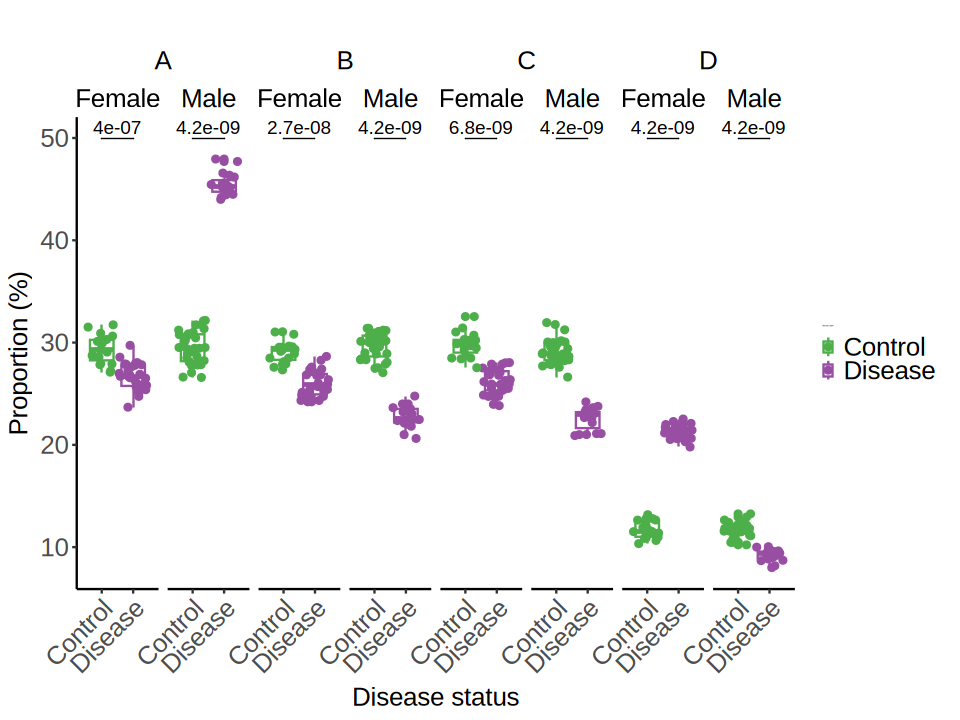

In [19]:
options(repr.plot.width=8, repr.plot.height=6)


meta_data %>%
  dplyr::group_by(subject_id,sex,disease,cell_type) %>%
  dplyr::summarise(count = dplyr::n()) %>%
  dplyr::group_by(subject_id,sex,disease) %>%
  dplyr::mutate(proportion = 100*count/sum(count),
                sex_label = ifelse(sex=="0","Male","Female"),
                disease_label = ifelse(disease=="0","Control","Disease")) %>%
  ggplot(.,aes(x=disease_label,y=proportion,color = disease_label)) +
  geom_boxplot() +
  geom_point(position=position_jitterdodge(0.9)) +
  ggpubr::stat_compare_means(comparisons = list(c("Control","Disease")), 
                             label = "{p.adj}{p.adj.signif}", method = "wilcox.test", label.y.npc = 0.4, tip.length = 0) +
  scale_color_manual(values = c(
    "Control" = "#4DAF4A",
    "Disease" = "#984EA3")) +
  ggh4x::facet_nested_wrap(vars(cell_type, sex_label), nrow = 1) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black"),
        strip.text.y=element_text(size=15, color="black"),
        strip.placement = "outside", 
        strip.background.x=element_rect(color = NA,  fill=NA), 
        strip.background.y=element_rect(color = "black",  fill=NA),
        legend.position = "right",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(
    x = "Disease status",
    y = "Proportion (%)",
    title = ""
  )  


# Scenario 4: Differential nteraction effect between sex and disease status

In [20]:
params <- list(
  n_thread = 1,
  n_cells = 50,
  n_individuals = 100,
  cluster_ratio = 0.65,
  batch_ratio = 0
)


In [21]:

fc_interact=1 # additional FC of specified cell types which are from people with case groups compared to control groups (e.g., if you specify 0.5, FC comparing increased cell type between case and control groups will be 1.5 in total)
interaction_type = c("differential") # c("specific","differential","opposite")


In [22]:
n_thread=params$n_thread
registerDoParallel(cores = n_thread)  # use forking with X cores

# parameters for generating dummy dataset
n_cells=params$n_cells # cells per major cell type
sd_celltypes=0.1  # standard deviation of number of cells 
n_major_cell_types=3 # number of major cell types
n_minor_cell_types=1 # number of minor cell types
relative_abundance=0.4 # ratio between major and rare
n_individuals=params$n_individuals # total individuals
n_batchs=4 # total batches
prop_sex=0.5 # proportion of female
prop_disease=0.5  # proportion of case
interaction_feature_1="sex"
interaction_feature_2="disease"
# interaction_feature_1="age"
# interaction_feature_2="bmi"
n_major_interact_celltypes=1 # number of major cell types which are differentially abundant between two groups. This parameter is effective only when fc_increase > 0
n_minor_interact_celltypes=1 # number of minor cell types which are differentially abundant between two groups. This parameter is effective only when fc_increase > 0

print(paste0("n_thread: ", n_thread))
print(paste0("n_cells: ", n_cells))
print(paste0("sd_celltypes: ", sd_celltypes))
print(paste0("n_major_cell_types: ", n_major_cell_types))
print(paste0("n_minor_cell_types: ", n_minor_cell_types))
print(paste0("relative_abundance: ", relative_abundance))
print(paste0("n_major_diff_celltypes: ", n_major_interact_celltypes))
print(paste0("n_minor_diff_celltypes: ", n_minor_interact_celltypes))
print(paste0("n_individuals: ", n_individuals))
print(paste0("n_batchs: ", n_batchs))
print(paste0("prop_sex: ", prop_sex))
print(paste0("prop_disease: ", prop_disease))
print(paste0("fc_interact: ", fc_interact))
print(paste0("interaction_type: ", interaction_type))


n_features = 200
cluster_features = 1:50
disease_features = 1:50
sex_features = 1:50 # seq(2, 20, by = 2)
age_features = 1:50 # seq(2, 10, by = 2)
bmi_features = 1:50 # seq(11, 20, by = 2)
batch_features = 1:100 # seq(1, 20,by = 2)
individual_features = 1:100 # seq(1, 20,by = 2)

# Define the maximum variance in features of each attribute
cluster_ratio = params$cluster_ratio
disease_ratio = 0.01
sex_ratio = 0.01 # 0.05
age_ratio = 0.01 # 0.05
bmi_ratio = 0.01 # 0.05
batch_ratio = params$batch_ratio # 0.1
individual_ratio = 0.01 # 0.1

n_pcs = 20

ratio_variance = 0.1

cluster_col = "cell_type"
sex_col = "sex"
age_col = "age"
bmi_col = "bmi"
batch_col = "batch"
disease_col = "disease"
individual_col = 'subject_id'

# parameters for UMAP
n_neighbors = 30
metric = "cosine"
min_dist = 0.01

samplem_key = 'subject_id'

# parameters for eQTL
eqtl_celltype = "A" # major cell type
eqtl_gene = "Gene1" # gene to be tested for eQTL
cor_vals = c(0, 0.15, 0.3) # correlation coefficients to be tested between expression of eqtl_gene in eqtl_celltype and genotype (dosage)
allele_freqs = c(0.05, 0.3) # allele frequencies to be tested
n_snps = 100 # number of simulation SNPs
dist_type = "nb" # c("nb","poisson") # distribution of simulated counts. nb= negative binomial, poisson= Poisson distribution
seed = 1234


[1] "n_thread: 1"
[1] "n_cells: 50"
[1] "sd_celltypes: 0.1"
[1] "n_major_cell_types: 3"
[1] "n_minor_cell_types: 1"
[1] "relative_abundance: 0.4"
[1] "n_major_diff_celltypes: 1"
[1] "n_minor_diff_celltypes: 1"
[1] "n_individuals: 100"
[1] "n_batchs: 4"
[1] "prop_sex: 0.5"
[1] "prop_disease: 0.5"
[1] "fc_interact: 1"
[1] "interaction_type: differential"


In [23]:
datasets = generate_data_interaction(n_cells = n_cells,
                                     sd_celltypes = sd_celltypes, 
                                     n_major_cell_types = n_major_cell_types,
                                     n_minor_cell_types = n_minor_cell_types,
                                     relative_abundance = relative_abundance, 
                                     n_major_interact_celltypes = n_major_interact_celltypes,
                                     n_minor_interact_celltypes = n_minor_interact_celltypes,
                                     interaction_feature_1 = interaction_feature_1,
                                     interaction_feature_2 = interaction_feature_2,
                                     interaction_type = interaction_type,
                                     
                                     n_individuals = n_individuals,
                                     n_batchs = n_batchs,
                                     prop_sex = prop_sex, 
                                     prop_disease = prop_disease, 
                                     fc_interact = fc_interact,
                                     
                                     n_features = n_features, 
                                     cluster_features = cluster_features,
                                     disease_features = disease_features,
                                     sex_features = sex_features, 
                                     age_features = age_features,
                                     bmi_features = bmi_features,
                                     batch_features = batch_features,
                                     individual_features = individual_features,
                                     
                                     cluster_ratio = cluster_ratio,
                                     disease_ratio = disease_ratio,
                                     sex_ratio = sex_ratio,
                                     age_ratio = age_ratio,
                                     bmi_ratio = bmi_ratio,
                                     batch_ratio = batch_ratio,
                                     individual_ratio = individual_ratio,
                                     
                                     ratio_variance = ratio_variance,
                                     
                                     cluster_col = cluster_col,
                                     sex_col = sex_col,
                                     age_col = age_col,
                                     bmi_col = bmi_col,
                                     batch_col = batch_col,
                                     disease_col = disease_col,
                                     individual_col = individual_col,
                                     
                                     dist_type = dist_type,
                                     eqtl_celltype = eqtl_celltype, 
                                     eqtl_gene = eqtl_gene,
                                     cor_vals = cor_vals,
                                     allele_freqs = allele_freqs,
                                     n_snps = n_snps, 
                                     
                                     seed = seed,
                                     n_thread = n_thread,
                                     verbose = TRUE
                                     
)

interaction_type; differential

The simulated dataset contains 400 pseudobulk samples across 100 individuals,
4 cell types,
400 genes,
with 23623 single cells in total.



In [24]:
meta_data = datasets$dummy_data
head(meta_data)
dim(meta_data)

,subject_id,sex,disease,age,batch,bmi,interaction,interact_term,cell_type,nUMI
,<chr>,<fct>,<fct>,<int>,<fct>,<int>,<chr>,<fct>,<chr>,<dbl>
61,SUB_1,1,1,33,1,31,sex:disease,1.1,A,394
16368,SUB_7,1,1,43,3,26,sex:disease,1.1,A,410
21879,SUB_93,0,1,37,1,31,sex:disease,0.1,A,334
22392,SUB_94,1,1,24,2,32,sex:disease,1.1,C,328
16904,SUB_72,1,0,25,4,27,sex:disease,1.0,A,236
18263,SUB_78,0,0,39,2,33,sex:disease,0.0,B,274


[1] 23623    10

`summarise()` has grouped output by 'subject_id', 'sex', 'disease'. You can
override using the `.groups` argument.


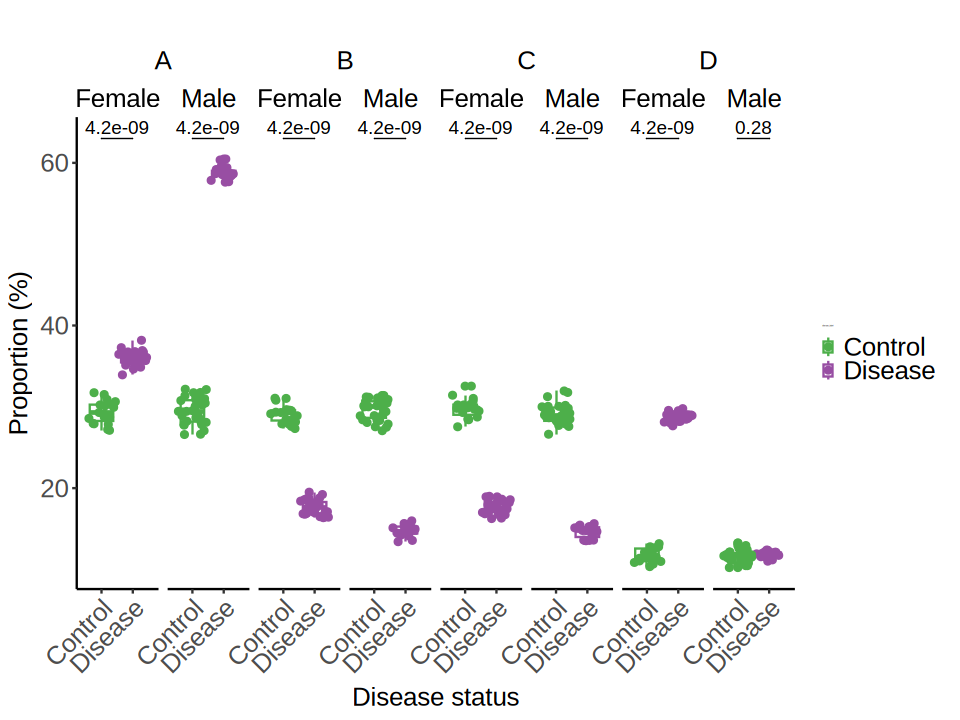

In [25]:
options(repr.plot.width=8, repr.plot.height=6)


meta_data %>%
  dplyr::group_by(subject_id,sex,disease,cell_type) %>%
  dplyr::summarise(count = dplyr::n()) %>%
  dplyr::group_by(subject_id,sex,disease) %>%
  dplyr::mutate(proportion = 100*count/sum(count),
                sex_label = ifelse(sex=="0","Male","Female"),
                disease_label = ifelse(disease=="0","Control","Disease")) %>%
  ggplot(.,aes(x=disease_label,y=proportion,color = disease_label)) +
  geom_boxplot() +
  geom_point(position=position_jitterdodge(0.9)) +
  ggpubr::stat_compare_means(comparisons = list(c("Control","Disease")), 
                             label = "{p.adj}{p.adj.signif}", method = "wilcox.test", label.y.npc = 0.4, tip.length = 0) +
  scale_color_manual(values = c(
    "Control" = "#4DAF4A",
    "Disease" = "#984EA3")) +
  ggh4x::facet_nested_wrap(vars(cell_type, sex_label), nrow = 1) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black"),
        strip.text.y=element_text(size=15, color="black"),
        strip.placement = "outside", 
        strip.background.x=element_rect(color = NA,  fill=NA), 
        strip.background.y=element_rect(color = "black",  fill=NA),
        legend.position = "right",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(
    x = "Disease status",
    y = "Proportion (%)",
    title = ""
  )  


# Scenario 5: Opposite nteraction effect between sex and disease status

In [26]:
params <- list(
  n_thread = 1,
  n_cells = 50,
  n_individuals = 100,
  cluster_ratio = 0.65,
  batch_ratio = 0
)


In [27]:

fc_interact=1 # additional FC of specified cell types which are from people with case groups compared to control groups (e.g., if you specify 0.5, FC comparing increased cell type between case and control groups will be 1.5 in total)
interaction_type = c("opposite") # c("specific","differential","opposite")


In [28]:
n_thread=params$n_thread
registerDoParallel(cores = n_thread)  # use forking with X cores

# parameters for generating dummy dataset
n_cells=params$n_cells # cells per major cell type
sd_celltypes=0.1  # standard deviation of number of cells 
n_major_cell_types=3 # number of major cell types
n_minor_cell_types=1 # number of minor cell types
relative_abundance=0.4 # ratio between major and rare
n_individuals=params$n_individuals # total individuals
n_batchs=4 # total batches
prop_sex=0.5 # proportion of female
prop_disease=0.5  # proportion of case
interaction_feature_1="sex"
interaction_feature_2="disease"
# interaction_feature_1="age"
# interaction_feature_2="bmi"
n_major_interact_celltypes=1 # number of major cell types which are differentially abundant between two groups. This parameter is effective only when fc_increase > 0
n_minor_interact_celltypes=1 # number of minor cell types which are differentially abundant between two groups. This parameter is effective only when fc_increase > 0

print(paste0("n_thread: ", n_thread))
print(paste0("n_cells: ", n_cells))
print(paste0("sd_celltypes: ", sd_celltypes))
print(paste0("n_major_cell_types: ", n_major_cell_types))
print(paste0("n_minor_cell_types: ", n_minor_cell_types))
print(paste0("relative_abundance: ", relative_abundance))
print(paste0("n_major_diff_celltypes: ", n_major_interact_celltypes))
print(paste0("n_minor_diff_celltypes: ", n_minor_interact_celltypes))
print(paste0("n_individuals: ", n_individuals))
print(paste0("n_batchs: ", n_batchs))
print(paste0("prop_sex: ", prop_sex))
print(paste0("prop_disease: ", prop_disease))
print(paste0("fc_interact: ", fc_interact))
print(paste0("interaction_type: ", interaction_type))


n_features = 200
cluster_features = 1:50
disease_features = 1:50
sex_features = 1:50 # seq(2, 20, by = 2)
age_features = 1:50 # seq(2, 10, by = 2)
bmi_features = 1:50 # seq(11, 20, by = 2)
batch_features = 1:100 # seq(1, 20,by = 2)
individual_features = 1:100 # seq(1, 20,by = 2)

# Define the maximum variance in features of each attribute
cluster_ratio = params$cluster_ratio
disease_ratio = 0.01
sex_ratio = 0.01 # 0.05
age_ratio = 0.01 # 0.05
bmi_ratio = 0.01 # 0.05
batch_ratio = params$batch_ratio # 0.1
individual_ratio = 0.01 # 0.1

n_pcs = 20

ratio_variance = 0.1

cluster_col = "cell_type"
sex_col = "sex"
age_col = "age"
bmi_col = "bmi"
batch_col = "batch"
disease_col = "disease"
individual_col = 'subject_id'

# parameters for UMAP
n_neighbors = 30
metric = "cosine"
min_dist = 0.01

samplem_key = 'subject_id'

# parameters for eQTL
eqtl_celltype = "A" # major cell type
eqtl_gene = "Gene1" # gene to be tested for eQTL
cor_vals = c(0, 0.15, 0.3) # correlation coefficients to be tested between expression of eqtl_gene in eqtl_celltype and genotype (dosage)
allele_freqs = c(0.05, 0.3) # allele frequencies to be tested
n_snps = 100 # number of simulation SNPs
dist_type = "nb" # c("nb","poisson") # distribution of simulated counts. nb= negative binomial, poisson= Poisson distribution
seed = 1234


[1] "n_thread: 1"
[1] "n_cells: 50"
[1] "sd_celltypes: 0.1"
[1] "n_major_cell_types: 3"
[1] "n_minor_cell_types: 1"
[1] "relative_abundance: 0.4"
[1] "n_major_diff_celltypes: 1"
[1] "n_minor_diff_celltypes: 1"
[1] "n_individuals: 100"
[1] "n_batchs: 4"
[1] "prop_sex: 0.5"
[1] "prop_disease: 0.5"
[1] "fc_interact: 1"
[1] "interaction_type: opposite"


In [29]:
datasets = generate_data_interaction(n_cells = n_cells,
                                     sd_celltypes = sd_celltypes, 
                                     n_major_cell_types = n_major_cell_types,
                                     n_minor_cell_types = n_minor_cell_types,
                                     relative_abundance = relative_abundance, 
                                     n_major_interact_celltypes = n_major_interact_celltypes,
                                     n_minor_interact_celltypes = n_minor_interact_celltypes,
                                     interaction_feature_1 = interaction_feature_1,
                                     interaction_feature_2 = interaction_feature_2,
                                     interaction_type = interaction_type,
                                     
                                     n_individuals = n_individuals,
                                     n_batchs = n_batchs,
                                     prop_sex = prop_sex, 
                                     prop_disease = prop_disease, 
                                     fc_interact = fc_interact,
                                     
                                     n_features = n_features, 
                                     cluster_features = cluster_features,
                                     disease_features = disease_features,
                                     sex_features = sex_features, 
                                     age_features = age_features,
                                     bmi_features = bmi_features,
                                     batch_features = batch_features,
                                     individual_features = individual_features,
                                     
                                     cluster_ratio = cluster_ratio,
                                     disease_ratio = disease_ratio,
                                     sex_ratio = sex_ratio,
                                     age_ratio = age_ratio,
                                     bmi_ratio = bmi_ratio,
                                     batch_ratio = batch_ratio,
                                     individual_ratio = individual_ratio,
                                     
                                     ratio_variance = ratio_variance,
                                     
                                     cluster_col = cluster_col,
                                     sex_col = sex_col,
                                     age_col = age_col,
                                     bmi_col = bmi_col,
                                     batch_col = batch_col,
                                     disease_col = disease_col,
                                     individual_col = individual_col,
                                     
                                     dist_type = dist_type,
                                     eqtl_celltype = eqtl_celltype, 
                                     eqtl_gene = eqtl_gene,
                                     cor_vals = cor_vals,
                                     allele_freqs = allele_freqs,
                                     n_snps = n_snps, 
                                     
                                     seed = seed,
                                     n_thread = n_thread,
                                     verbose = TRUE
                                     
)

interaction_type; opposite

The simulated dataset contains 377 pseudobulk samples across 100 individuals,
4 cell types,
377 genes,
with 16665 single cells in total.



In [30]:
meta_data = datasets$dummy_data
head(meta_data)
dim(meta_data)

,subject_id,sex,disease,age,batch,bmi,interaction,interact_term,cell_type,nUMI
,<chr>,<fct>,<fct>,<int>,<fct>,<int>,<chr>,<fct>,<chr>,<dbl>
61,SUB_1,1,1,33,1,31,sex:disease,1.1,C,356
16368,SUB_98,0,1,57,2,26,sex:disease,0.1,A,314
6703,SUB_45,1,1,26,1,33,sex:disease,1.1,C,333
1560,SUB_17,0,0,28,1,15,sex:disease,0.0,D,396
10312,SUB_65,1,0,54,1,35,sex:disease,1.0,C,307
1292,SUB_15,0,1,48,3,17,sex:disease,0.1,B,318


[1] 16665    10

`summarise()` has grouped output by 'subject_id', 'sex', 'disease'. You can
override using the `.groups` argument.


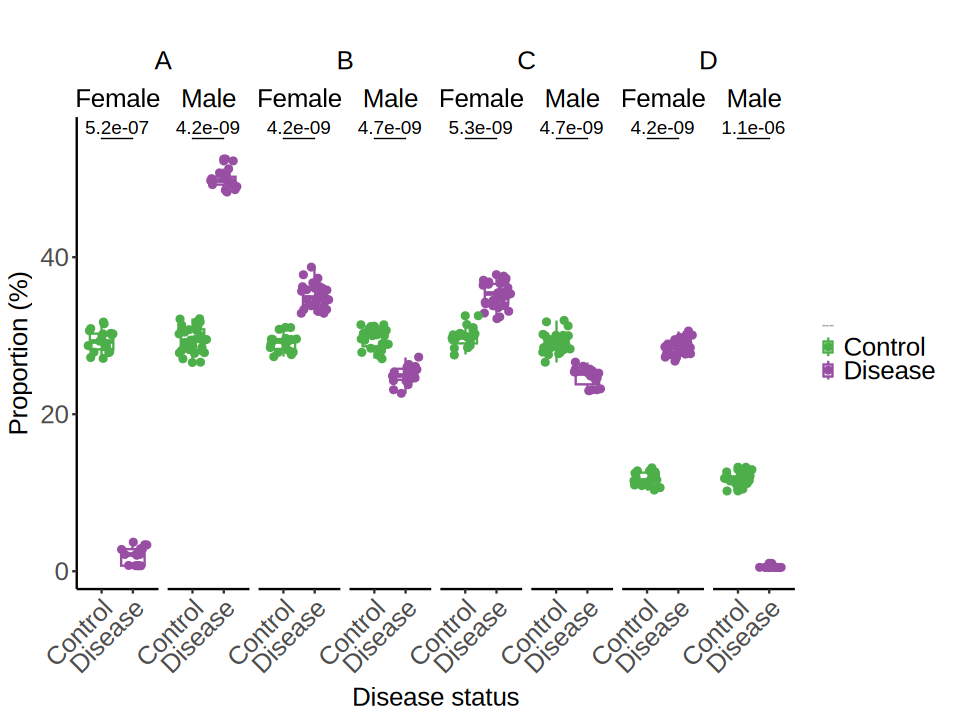

In [31]:
options(repr.plot.width=8, repr.plot.height=6)


meta_data %>%
  dplyr::group_by(subject_id,sex,disease,cell_type) %>%
  dplyr::summarise(count = dplyr::n()) %>%
  dplyr::group_by(subject_id,sex,disease) %>%
  dplyr::mutate(proportion = 100*count/sum(count),
                sex_label = ifelse(sex=="0","Male","Female"),
                disease_label = ifelse(disease=="0","Control","Disease")) %>%
  ggplot(.,aes(x=disease_label,y=proportion,color = disease_label)) +
  geom_boxplot() +
  geom_point(position=position_jitterdodge(0.9)) +
  ggpubr::stat_compare_means(comparisons = list(c("Control","Disease")), 
                             label = "{p.adj}{p.adj.signif}", method = "wilcox.test", label.y.npc = 0.4, tip.length = 0) +
  scale_color_manual(values = c(
    "Control" = "#4DAF4A",
    "Disease" = "#984EA3")) +
  ggh4x::facet_nested_wrap(vars(cell_type, sex_label), nrow = 1) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black"),
        strip.text.y=element_text(size=15, color="black"),
        strip.placement = "outside", 
        strip.background.x=element_rect(color = NA,  fill=NA), 
        strip.background.y=element_rect(color = "black",  fill=NA),
        legend.position = "right",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(
    x = "Disease status",
    y = "Proportion (%)",
    title = ""
  )  
